# VariantSpark Example Analysis Notebook

## VaraintSpark has several interfaces including: Python API, Hail Integration and Command Line Interface. This notebook showcase VariantSpark integration with Hail library.

## In this note book we use a synthetic dataset called Hipster (see description below).

![VariantSpark](https://s3.us-east-2.amazonaws.com/csiro-graphics/variant-spark.png)
* [**VariantSpark**](http://bioinformatics.csiro.au/variantspark) is a machine learning library for real-time genomic data analysis (for thousands of samples and millions of variants) and is...  
  * Built on top of Apache Spark and written in Scala
  * Authored by the team at [CSIRO Bioinformatics](http://bioinformatics.csiro.au/) in Australia
  * Uses a custom machine learning **random forest** implementation to find the most *important* variants attributing to a phenotype of interest   
* This demo...  
  * Includes a dataset with a subset of the samples and variants (in VCF format) from the 1000 Genomes Project  
  * Uses a synthetic phenotype called *HipsterIndex* (in CSV format) factoring various real phenotypes (monobrow, beard, etc.)

## Hipster Index

The synthetic HipsterIndex was created based on the 1000 Genome Project data using the following four genotypes:

| ID |SNP ID     | chromosome | position | phenotype | reference |
|---:|----------:|----:|-------:|-----:|----------:|
| B6 |[rs2218065](https://www.ncbi.nlm.nih.gov/projects/SNP/snp_ref.cgi?rs=2218065) | chr2 | 223034082 | monobrow | [Adhikari K, et al. (2016) Nat Commun.](https://www.ncbi.nlm.nih.gov/pubmed/?term=26926045) |
| R1 |[rs1363387](https://www.ncbi.nlm.nih.gov/projects/SNP/snp_ref.cgi?rs=1363387) | chr5 | 126626044 | Retina horizontal cells (checks) | [Kay, JN et al. (2012) Nature](https://www.ncbi.nlm.nih.gov/pubmed/?term=22407321)
| B2 |[rs4864809](https://www.ncbi.nlm.nih.gov/projects/SNP/snp_ref.cgi?rs=4864809) | chr4 |  54511913 | beard | [Adhikari K, et al. (2016) Nat Commun.](https://www.ncbi.nlm.nih.gov/pubmed/?term=26926045)
| C2 |[rs4410790](https://www.ncbi.nlm.nih.gov/projects/SNP/snp_ref.cgi?rs=4410790)  |chr7 |17284577| coffee consumption        | [Cornelis MC et al. (2011) PLoS Genet.](https://www.ncbi.nlm.nih.gov/pubmed/?term=21490707) |

To simulate phenotype, we first encode genotypes to integers in the following manner: *homozygote* reference encoded as 0, *heterozygote* as 1 and *homozygote alternative* as 2. Then we compute the score for each sample using the following equation.

`Score = (5*B6*B2 – 4*B6 – 4*B2 + 1) + (7*R1*C2 – 6*R1 – 6*C2 + 1)`

Next, we add noise to the score where noise is a random number with normal distribution, `mean = 0` and `standard deviation = 6`. Finally, we sort samples by `score+noise` and take the first half of as controls and the second half as cases. By doing so, we created a binary annotation for the individuals.

In the rest of this notebook, we will demonstrate the usage of VariantSpark to reverse-engineer the association of the selected SNPs to the phenotype of interest (i.e. being a hipster). We also use traditional GWAS approach and its failure to identify significant SNPs when there are complex interactions.

### Set the number of CPUs of the cluster

In [1]:
numCPU=32

# Set Demo to True to quickly run the notebook on a very small dataset with 20K SNPs
# Set Demo to False to process 500,000 SNPs
Demo=True 

numPartition=numCPU*4

### Initialisation

In [2]:
%%juspark
{"spark.driver.memory":"24G","spark.jars":"/home/hadoop/miniconda2/envs/jupyter/lib/python2.7/site-packages/varspark/jars/varspark.jar"}


PySpark initialised: spark context available as sc


In [3]:
import hail
import varspark.hail
hc = hail.HailContext(sc)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from math import log, isnan
from pprint import pprint
from decimal import Decimal
from hail import KeyTable
from hail.keytable import asc
from hail.keytable import desc

Running on Apache Spark version 2.2.1
SparkUI available at http://ip-71-49-240-241.ap-southeast-2.compute.internal:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.1-20613ed


### This code snip used to generate Manhattan plot where the associated SNPs are highlighted with different colors

In [4]:
def ColorImportant(pd):
    pd['c'] = "silver"
    pd.loc[pd['chr'] == '1', 'c']  = "lightgrey"
    pd.loc[pd['chr'] == '3', 'c']  = "lightgrey"
    pd.loc[pd['chr'] == '5', 'c']  = "lightgrey"
    pd.loc[pd['chr'] == '7', 'c']  = "lightgrey"
    pd.loc[pd['chr'] == '9', 'c']  = "lightgrey"
    pd.loc[pd['chr'] == '11', 'c'] = "lightgrey"
    pd.loc[pd['chr'] == '13', 'c'] = "lightgrey"
    pd.loc[pd['chr'] == '15', 'c'] = "lightgrey"
    pd.loc[pd['chr'] == '17', 'c'] = "lightgrey"
    pd.loc[pd['chr'] == '19', 'c'] = "lightgrey"
    pd.loc[pd['chr'] == '21', 'c'] = "lightgrey"
    
    pd.loc[pd['jk'] == '2_223034082', 'c'] = "black"  #B6
    pd.loc[pd['jk'] == '4_54511913' , 'c'] = "red"   #B2
    pd.loc[pd['jk'] == '5_126626044', 'c'] = "green" #R1
    pd.loc[pd['jk'] == '7_17284577'  , 'c'] = "blue" #C2
    
    pd['Important'] = False
    
    pd.loc[pd['jk'] == '2_223034082', 'Important'] = True #B6
    pd.loc[pd['jk'] == '4_54511913' , 'Important'] = True #B2
    pd.loc[pd['jk'] == '5_126626044', 'Important'] = True #R1
    pd.loc[pd['jk'] == '7_17284577' , 'Important'] = True #C2
    return pd

ofs = [
    0,
    0,         # offset for chr1
    249250621, # offset for chr2
    492449994, # offset for chr3
    690472424,
    881626700,
    1062541960,
    1233657027,
    1392795690,
    1539159712,
    1680373143,
    1815907890,
    1950914406,
    2084766301,
    2199936179,
    2307285719,
    2409817111,
    2500171864,
    2581367074,
    2659444322,
    2722469842,
    2781598825,
    2832903391
]


### Load phenotypes data from a public S3 bucket

In [5]:
table = hc.import_table('s3://variant-spark/datasets/Hipster2Small/Hipster.csv', delimiter=',', impute=True)\
.key_by('Sample')

# For details of important variant please refere to the following link
# https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/8497971343024764/53198984527781/2559267461126367/latest.html
intervals = map(hail.representation.Interval.parse, ['2:223034081-223034083', '5:126626043-126626045', '4:54511912-54511914', "7:17284576-17284578"])


2019-08-06 05:28:17 Hail: INFO: Reading table to impute column types
2019-08-06 05:28:20 Hail: INFO: Finished type imputation
  Loading column `Sample' as type String (imputed)
  Loading column `B6' as type Int (imputed)
  Loading column `R1' as type Int (imputed)
  Loading column `B2' as type Int (imputed)
  Loading column `C2' as type Int (imputed)
  Loading column `Score' as type Int (imputed)
  Loading column `Score+Noise' as type Double (imputed)
  Loading column `Hipster' as type Int (imputed)
  Loading column `Noise' as type Double (imputed)
  Loading column `isCase' as type Boolean (imputed)
  Loading column `population' as type String (imputed)


### Synthetic phenotype report including distribution of "Score", "Noise" and "Score+Noise" as well as number of Case and controls

In [6]:
tpd = table.to_pandas()

In [7]:
tpd.head(5)

,Sample,B6,R1,B2,C2,Score,Score+Noise,Hipster,Noise,isCase,population
0,HG00096,0,0,1,1,14,12.817494,0,-1.18251,False,Control
1,HG00097,2,2,0,1,12,13.112307,0,1.11231,False,Control
2,HG00099,1,1,0,0,14,20.151686,1,6.15169,True,Case
3,HG00100,1,1,0,1,15,7.243478,0,-7.75652,False,Control
4,HG00101,2,0,0,1,10,5.233279,0,-4.76672,False,Control


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3409f39950>]],
      dtype=object)

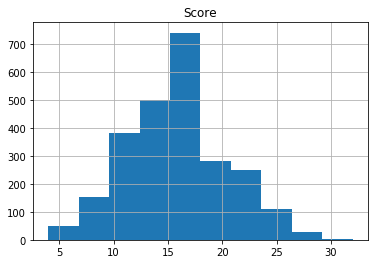

In [8]:
tpd.hist('Score')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3409e8ba50>]],
      dtype=object)

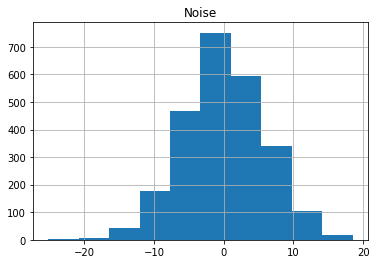

In [9]:
tpd.hist('Noise')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3408cfa8d0>]],
      dtype=object)

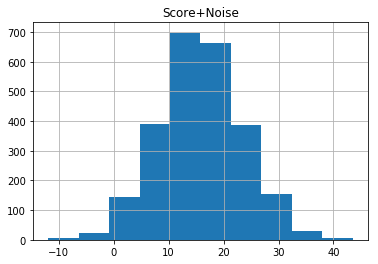

In [10]:
tpd.hist('Score+Noise')

In [11]:
tpd.groupby('isCase')['Sample'].count()

isCase
False    1252
True     1252
Name: Sample, dtype: int64

### Load VCF from a public s3 bucket and import it to Hail VDS format
### You should specify the number number of tree for VariantSpark analysis 

In [12]:
vcf='s3://variant-spark/datasets/Hipster2Small/Small.558938.vcf.bgz'
rate=0.001 # rate of SNPs to be used to compute PCA vectors
nTree=1000 # number of trees
    
if Demo==True:
    vcf='s3://variant-spark/datasets/Hipster2Small/Tiny.vcf.bgz'
    rate=0.05 # rate of SNPs to be used to compute PCA vectors
    nTree=100 # number of trees


In [13]:
caseCtrlVds = hc.import_vcf(vcf).repartition(numPartition).cache()

2019-08-06 05:28:31 Hail: INFO: No multiallelics detected.
2019-08-06 05:28:31 Hail: INFO: Coerced sorted dataset


### Count Number of samples and SNPs in the dataset
### - The first number is the number of samples
### - The second number is the number of SNPs

In [14]:
print(caseCtrlVds.count())

(2504L, 22487L)


### Annotate Hail VDS dataset with the phenotype

In [15]:
caseCtrlVds = caseCtrlVds.annotate_samples_table(table, root='sa.pheno')

### Compute PCA vectors using Hail library and plot the first PCA vectors.
### The plot shows no structural difference between case and control group.

2019-08-06 05:28:52 Hail: INFO: Running PCA with 2 components...


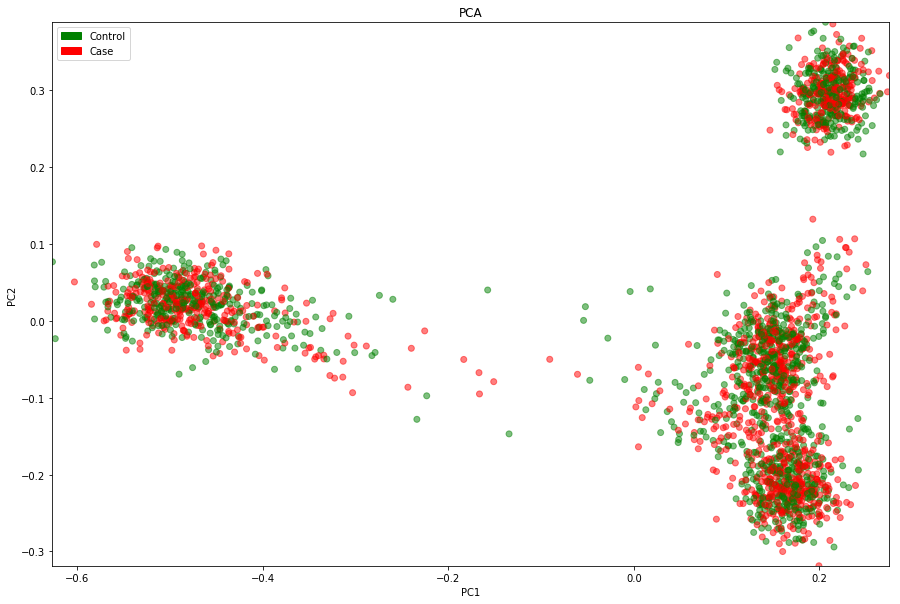

In [16]:
pca_kt = caseCtrlVds.sample_variants(rate).cache()\
.pca(k=2, scores='sa.pca_score', loadings='va.pca_loadings', eigenvalues='global.pca_evals')\
.samples_table()

pca_table = pca_kt.to_pandas()

colors = {'Control': 'green', 'Case': 'red'}
plt.figure(figsize=(15,10))
plt.scatter(pca_table["sa.pca_score.PC1"], pca_table["sa.pca_score.PC2"],
            c = pca_table["sa.pheno.population"].map(colors),
            alpha = .5)
plt.xlim(pca_table["sa.pca_score.PC1"].min(), pca_table["sa.pca_score.PC1"].max())
plt.ylim(pca_table["sa.pca_score.PC2"].min(), pca_table["sa.pca_score.PC2"].max())
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA")
legend_entries = [mpatches.Patch(color=c, label=pheno) for pheno, c in colors.items()]
plt.legend(handles=legend_entries, loc=2)
plt.show()

caseCtrlVds = caseCtrlVds.annotate_samples_table(pca_kt, root='sa.pca')

del pca_kt
del pca_table

### Association test using VariantSpark

In [17]:
%%sh
date +%s > time.txt

In [18]:
vskt = caseCtrlVds.importance_analysis("sa.pheno.Hipster", n_trees = nTree, mtry_fraction = 0.1, oob = False,\
                                       seed = 13L,  batch_size = 100)\
.important_variants(1000000)\
.rename({'variant':'v'}).rename({'importance':'vsis'})\
.order_by(desc('vsis')).indexed('vs_rank').key_by('v')

### Annotate Hail VDS dataset with "Importance Score" computed using VariantSpark

In [19]:
caseCtrlVds = caseCtrlVds.annotate_variants_table(vskt, root='va.vsis')

2019-08-06 05:29:20 Hail: INFO: Ordering unsorted dataset with network shuffle


### Manhattan plot for VariantSpark "Importance Score" (z-score)
### The highlighted points show the SPNs which are used to simulate phenotype.

2019-08-06 05:29:20 Hail: INFO: interval filter loaded 4 of 128 partitions
2019-08-06 05:29:22 Hail: INFO: Ordering unsorted dataset with network shuffle


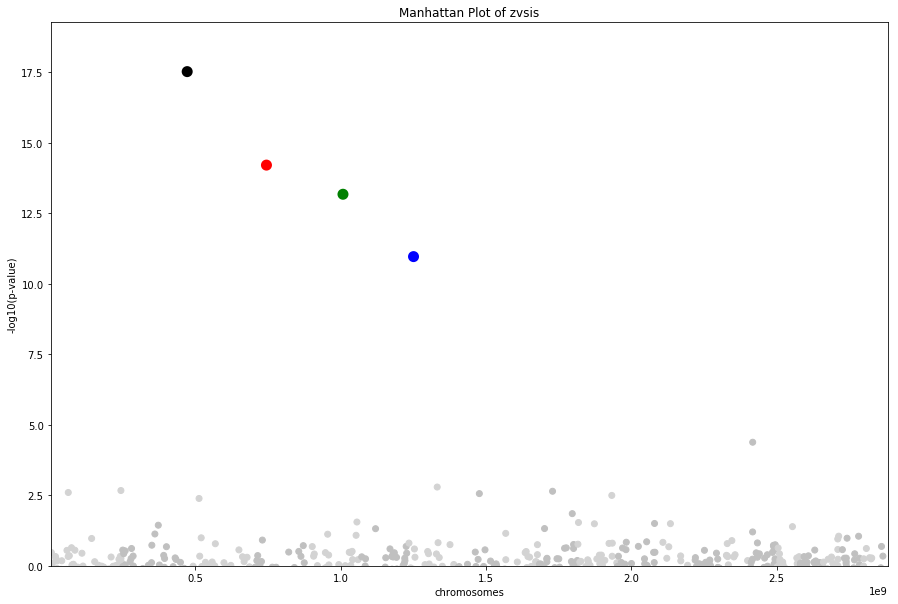

In [20]:
Important_var = caseCtrlVds.filter_intervals(intervals)

pdf = caseCtrlVds.filter_variants_expr('va.vsis.vs_rank < 1000', keep=True)\
.union(Important_var).deduplicate().variants_table()\
.expand_types().flatten()\
.rename({'va.vsis.vsis':'vsis'})\
.rename({'v.contig':'chr'})\
.rename({'v.start':'pos'})\
.key_by(['vsis'])\
.select(['vsis', 'pos', 'chr'])\
.annotate('jk = chr + "_" + pos').to_pandas()

key='zvsis'

pdf[key] = (pdf['vsis'] - pdf['vsis'].mean())/pdf['vsis'].std(ddof=0)

pdf['xpos'] = pdf.apply(lambda row: ofs[int(row['chr'])] + row['pos'], axis=1)
pdf = ColorImportant(pdf)
pdf2 = pdf.loc[pdf['Important'] == True]

plt.figure(figsize=(15,10))
plt.scatter(pdf['xpos'], pdf[key], c = pdf['c'])
plt.scatter(pdf2['xpos'], pdf2[key], c = pdf2['c'], linewidths=5)
plt.xlim(pdf['xpos'].min(), pdf['xpos'].max())
plt.ylim(0, pdf[key].max()*1.1)
plt.xlabel("chromosomes")
plt.ylabel('-log10(p-value)')
plt.title("Manhattan Plot of "+ key)
#legend_entries = [mpatches.Patch(color=c, label=pheno) for pheno, c in colors.items()]
#plt.legend(handles=legend_entries, loc=2)
plt.show()

In [21]:
%%sh
start=`cat time.txt`
end=`date +%s`
runtime=$((end-start))
echo "VriantSpark runtime is "$runtime "seconds"

VriantSpark runtime is 25 seconds


### Traditional GWAS using Logestic Regression (wald test implemented in Hail library)

In [22]:
%%sh
date +%s > time.txt

In [23]:
caseCtrlVds = caseCtrlVds\
.logreg(test='wald' , root='va.wald' , y='sa.pheno.isCase', \
        covariates=['sa.pca.pca_score.PC1', 'sa.pca.pca_score.PC2'])


2019-08-06 05:29:25 Hail: INFO: Running wald logistic regression on 2504 samples with 3 covariates including intercept...


### Manhattan plot for traditional GWAS with highlighted important SNPs
### The highlighted points show the SPNs which are used to simulate phenotype.
### The green one is far below the noise and the red one is hidden in the noise.

2019-08-06 05:29:25 Hail: INFO: interval filter loaded 4 of 128 partitions
2019-08-06 05:29:30 Hail: INFO: Ordering unsorted dataset with network shuffle


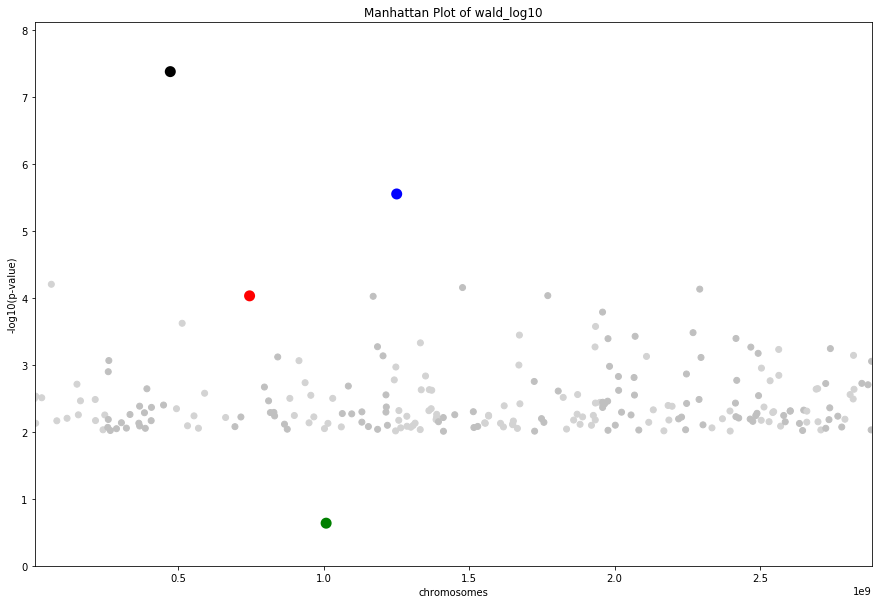

In [24]:
Important_var = caseCtrlVds.filter_intervals(intervals)

pdf = caseCtrlVds.filter_variants_expr('va.wald.pval < 0.01', keep=True)\
.union(Important_var).deduplicate().variants_table()\
.expand_types().flatten()\
.rename({'va.wald.pval':'wald_pval'})\
.rename({'v.contig':'chr'})\
.rename({'v.start':'pos'})\
.key_by(['wald_pval'])\
.select(['wald_pval', 'pos', 'chr'])\
.annotate('wald_log10 = -log10(wald_pval)')\
.annotate('jk = chr + "_" + pos').to_pandas()

key='wald_log10'

pdf['xpos'] = pdf.apply(lambda row: ofs[int(row['chr'])] + row['pos'], axis=1)
pdf = ColorImportant(pdf)
pdf2 = pdf.loc[pdf['Important'] == True]

plt.figure(figsize=(15,10))
plt.scatter(pdf['xpos'], pdf[key], c = pdf['c'])
plt.scatter(pdf2['xpos'], pdf2[key], c = pdf2['c'], linewidths=5)
plt.xlim(pdf['xpos'].min(), pdf['xpos'].max())
plt.ylim(0, pdf[key].max()*1.1)
plt.xlabel("chromosomes")
plt.ylabel('-log10(p-value)')
plt.title("Manhattan Plot of "+ key)
#legend_entries = [mpatches.Patch(color=c, label=pheno) for pheno, c in colors.items()]
#plt.legend(handles=legend_entries, loc=2)
plt.show()

In [25]:
%%sh
start=`cat time.txt`
end=`date +%s`
runtime=$((end-start))
echo "Traditional GWAS runtime is "$runtime "seconds"

Traditional GWAS runtime is 13 seconds
